# Physics Info Class

Contains information concerning cross sections of signal $\sigma_s$ and background $\sigma_b$, along with interpolation functions ($\sigma_s(m_{Z'})$ and $m_{Z'}(\sigma_s)$

In [14]:
import numpy as np
import scipy.interpolate

class PhysicsInfo():
    def __init__(self):
        self.manuel_masses = [350, 500, 750, 1000, 2000, 3000, 4000] # Z' masses (GeV) for which Manuel created signal samples
        self.manuel_css = [0.001395, 0.0007823, 0.0003429, 0.0001692, 1.808e-05, 1.325e-06, 4.456e-07] # cross sections (pb)
        self.manuel_log_css = np.log10(self.manuel_css)
        self.elijah_masses = [10, 50, 100, 200, 350, 500, 1000, 2000, 5000] # Z' masses (GeV) for which I created signal samples
        self.elijah_css = [9.801, 0.5445, 0.1442, 0.03622, 0.009998, 0.003802, 0.0003936, 2.034e-05, 2.748e-08] # cross sections (pb)  
        self.elijah_log_css = np.log10(self.elijah_css)
        self.manuelLogF = scipy.interpolate.interp1d(self.manuel_masses, self.manuel_log_css, kind='cubic')
        self.elijahLogF = scipy.interpolate.interp1d(self.elijah_masses, self.elijah_log_css, kind='cubic')
        self.elijahInvF = scipy.interpolate.interp1d(self.elijahLogF(self.elijah_masses), self.elijah_masses, kind='cubic')
        
        self.conv = 10**15 / 10**12 # cross sec (pb) * lumi (fb^{-1}) * conv = number of events
        
    def sig_cs(self, masses, who='E'):
        return np.power(10, self.elijahLogF(masses)) if who=='E' else np.power(10, self.manuelLogF(masses)) # pb
    
    def bg_cs(self, who='E', split=False):
        bg_css = [0.106, 0.0117, 5.58] if who=='E' else [0.1339, 0.01187, 5.603]
        return bg_css if split else sum(bg_css) # pb
    
    def Zp_mass(self, css):
        return self.elijahInvF(np.log10(css))

# Useful Constants and Arrays

In [15]:
import matplotlib.pyplot as plt

settings = {'axes.labelsize': 32,
            'xtick.major.size': 10,
            'xtick.major.width': 1.5,
            'xtick.labelsize': 24,
            'ytick.major.size': 10,
            'ytick.major.width': 1.5,
            'ytick.labelsize': 24,
            'legend.fontsize': 18,
            'lines.linewidth': 4,
            'lines.markersize': 10,
            'figure.figsize': (12,8)}

PI = PhysicsInfo()
Mpts = np.linspace(PI.manuel_masses[0], PI.manuel_masses[-1], 1000)
Epts = np.linspace(PI.elijah_masses[0], PI.elijah_masses[-1], 1000)
Minterp = PI.sig_cs(Mpts, who='M')
Einterp = PI.sig_cs(Epts, who='E')
bg_cs = PI.bg_cs()

# Z' mass $m_{Z'}$ vs signal cross section $\sigma$

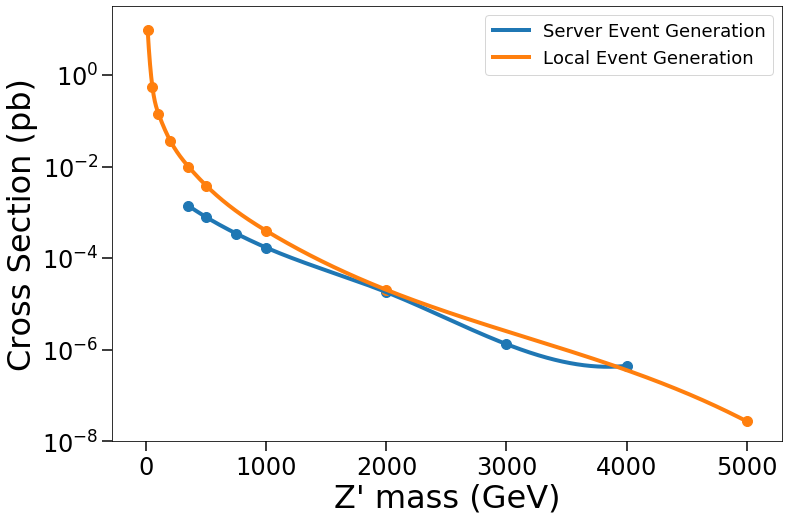

In [16]:
with plt.rc_context(settings):
    plt.plot(Mpts, Minterp, label='Server Event Generation')
    plt.plot(Epts, Einterp, label='Local Event Generation')
    plt.scatter(PI.manuel_masses, PI.manuel_css)
    plt.scatter(PI.elijah_masses, PI.elijah_css)
    plt.ylabel('Cross Section (pb)');
    plt.xlabel("Z' mass (GeV)");
    plt.ylim(10**-8, 10**1.5)
    plt.yscale('log')
    plt.legend()

# Required $\frac{TPR}{\sqrt{FPR}}$ vs $m_{Z'}$ for significance $= \frac{S}{\sqrt{B}}$

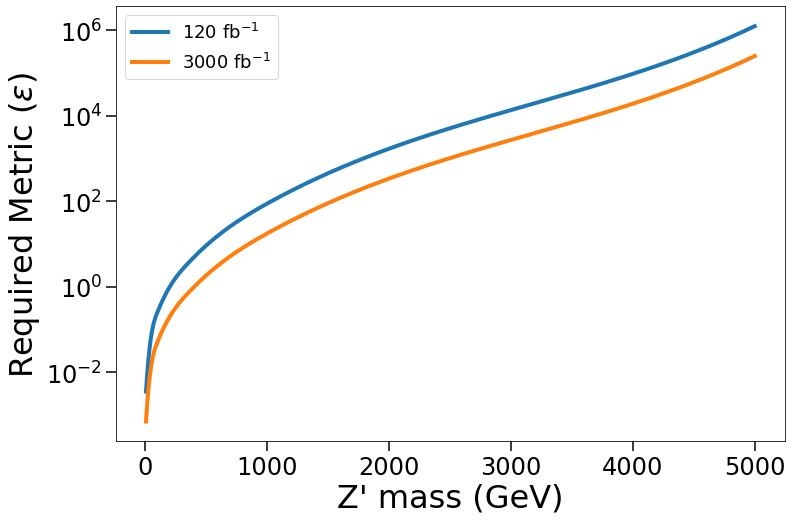

In [4]:
metric_req_l120 = 5 / ((PI.conv * Einterp * 120) / np.sqrt(PI.conv * bg_cs * 120))
metric_req_l3000 = 5 / ((PI.conv * Einterp * 3000) / np.sqrt(PI.conv * bg_cs * 3000))

with plt.rc_context(settings):
    plt.plot(Epts, metric_req_l120, label=r'120 fb$^{-1}$')
    plt.plot(Epts, metric_req_l3000, label=r'3000 fb$^{-1}$')
    plt.xlabel("Z' mass (GeV)")
    plt.ylabel("Required Metric ($\epsilon$)")
    plt.yscale('log')
    plt.legend()

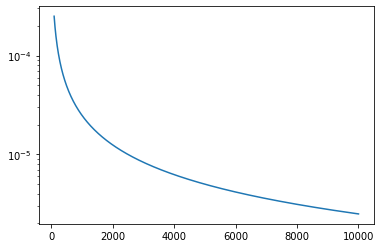

In [5]:
lumis = np.linspace(100, 10000, 1000)
sig = 5
needed_css = sig**2 / (lumis * PI.conv)
plt.plot(lumis, needed_css)
plt.yscale('log')

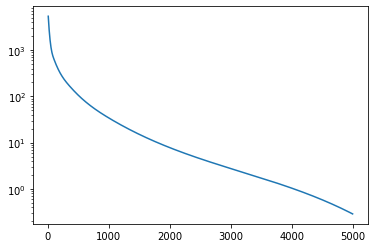

In [6]:
plt.plot(Epts, np.sqrt(PI.conv * Einterp * 3000))
plt.yscale('log')

In [12]:
PI = PhysicsInfo()
sig = 5
bg_cs = PI.bg_cs()
lumi = 3000 # fb
bg_yield = PI.conv * bg_cs * lumi

tprs = np.linspace(0.7, 1, 100)
fprs = np.sort(np.logspace(-4, np.log10(0.6), 100))

coef = [[[-(PI.conv * tpr * lumi)**2, sig**2 * PI.conv * tpr * lumi, sig**2 * fpr * bg_yield] for fpr in fprs] for tpr in tprs]
sig_cs = [[np.amax(np.roots(elem)) for elem in row] for row in coef]
masses = PI.Zp_mass(sig_cs)
log_masses = np.log10(masses)

# Maximal Z' mass sensitivity vs model TPR, FPR

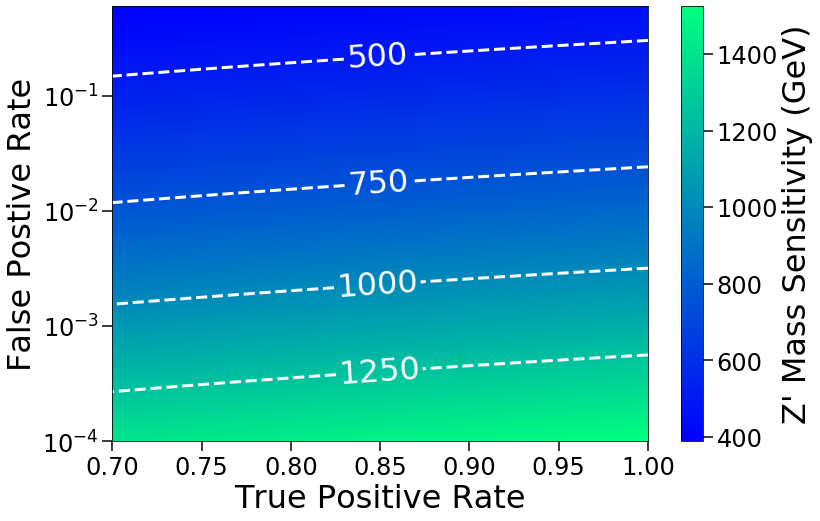

In [13]:
xs = tprs
ys = np.log10(fprs)
data = masses
res = 1000
cvalues = [500, 750, 1000, 1250]
clabels = [str(a) for a in cvalues]
manual = [(0.85, -1), (0.85, -2), (0.85, -3), (0.85, -3.5)]

ext = [xs[0], xs[-1], ys[0], ys[-1]]
pts = np.array([[x,y] for x in xs for y in ys])
data = np.array(data).flatten()
grid = np.array(
        [[[x,y] for x in np.linspace(ext[0], ext[1], res)]
        for y in np.linspace(ext[2], ext[3], res)])
interp = scipy.interpolate.griddata(pts, data, grid)

with plt.rc_context(settings):
    plt.imshow(interp, origin='lower', aspect='auto', extent=ext, cmap='winter')
    cbar = plt.colorbar()
    plt.xlabel(r'{}'.format('True Positive Rate'))
    plt.ylabel(r'{}'.format('False Postive Rate'))
    cbar.set_label(r'{}'.format("Z' Mass Sensitivity (GeV)"), rotation=90)
    result = plt.contour(grid[:,:,0], grid[:,:,1], interp, cvalues, colors='white',
                                 linewidths=3, linestyles='dashed')
    fmt = {lev:lab for lev, lab in zip(result.levels, clabels)}
    plt.clabel(result, result.levels, inline=True, fmt=fmt, fontsize=32,
               manual=manual)
    plt.yticks([-1, -2, -3, -4], [r'$10^{-1}$', r'$10^{-2}$', r'$10^{-3}$', r'$10^{-4}$'])

In [366]:
# maximal Z' mass that we can hope to be sensitive too: 
# any higher and we won't get 25 signal events from 3000 fb^{-1}
print(PI.Zp_mass(25 / (3000 * PI.conv)))

2363.0884562513575
